# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [102]:
#for math and data structure
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose as sd

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [103]:
df = pd.read_csv('zillow_data.csv')
display(df.head())
df.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Step 2: Data Preprocessing

In [104]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [105]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [106]:
# reshape from wide to long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [107]:
mdf = melt_data(df)
display(mdf.head())
mdf.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
RegionID      int64
RegionName    int64
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
Month         datetime64[ns]
MeanValue     float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


In [109]:
mdf.describe

<bound method NDFrame.describe of          RegionID  RegionName                 City State              Metro  \
0           84654       60657              Chicago    IL            Chicago   
1           90668       75070             McKinney    TX  Dallas-Fort Worth   
2           91982       77494                 Katy    TX            Houston   
3           84616       60614              Chicago    IL            Chicago   
4           93144       79936              El Paso    TX            El Paso   
...           ...         ...                  ...   ...                ...   
3901590     58333        1338             Ashfield    MA    Greenfield Town   
3901591     59107        3293            Woodstock    NH          Claremont   
3901592     75672       40404                Berea    KY           Richmond   
3901593     93733       81225  Mount Crested Butte    CO                NaN   
3901594     95851       89155             Mesquite    NV          Las Vegas   

        CountyNam

## Select Region for Investigation

In [110]:
# I'll look at the area I grew up in, since I know it well

dtw = mdf[(mdf.Metro == 'Detroit')].copy()
dtw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39414 entries, 121 to 3901238
Data columns (total 9 columns):
RegionID      39414 non-null int64
RegionName    39414 non-null int64
City          39414 non-null object
State         39414 non-null object
Metro         39414 non-null object
CountyName    39414 non-null object
SizeRank      39414 non-null int64
Month         39414 non-null datetime64[ns]
MeanValue     39414 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 3.0+ MB


In [111]:
dtw.RegionName.unique()

array([48180, 48185, 48066, 48187, 48044, 48307, 48183, 48170, 48111,
       48843, 48073, 48060, 48188, 48146, 48047, 48310, 48154, 48239,
       48127, 48186, 48124, 48195, 48312, 48313, 48178, 48021, 48071,
       48152, 48174, 48237, 48236, 48067, 48322, 48446, 48091, 48089,
       48101, 48317, 48045, 48116, 48309, 48336, 48080, 48192, 48220,
       48328, 48150, 48042, 48135, 48076, 48335, 48316, 48390, 48167,
       48092, 48315, 48340, 48093, 48329, 48326, 48075, 48306, 48009,
       48327, 48083, 48346, 48088, 48371, 48134, 48081, 48085, 48348,
       48331, 48168, 48314, 48382, 48033, 48169, 48442, 48393, 48114,
       48334, 48094, 48184, 48240, 48034, 48082, 48386, 48098, 48230,
       48072, 48084, 48043, 48304, 48059, 48193, 48323, 48302, 48051,
       48324, 48026, 48025, 48362, 48855, 48381, 48017, 48001, 48374,
       48301, 48836, 48173, 48079, 48462, 48383, 48138, 48040, 48360,
       48065, 48015, 48062, 48074, 48359, 48164, 48357, 48039, 48165,
       48356, 48455,

In [112]:
# making sure we don't have any null values
dtw.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
Month         0
MeanValue     0
dtype: int64

In [113]:
# setting the time as the index
dtw.set_index('Month', inplace=True)
dtw.head(10)

# note: we won't need all of these columns for our models
# we're moving onto some exploratory analysis, so let's keep them for now!

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,79040,48180,Taylor,MI,Detroit,Wayne,122,69000.0
1996-04-01,79044,48185,Westland,MI,Detroit,Wayne,239,94800.0
1996-04-01,78942,48066,Roseville,MI,Detroit,Macomb,580,76700.0
1996-04-01,79046,48187,Canton,MI,Detroit,Wayne,660,153700.0
1996-04-01,78926,48044,Macomb,MI,Detroit,Macomb,762,167400.0
1996-04-01,79118,48307,Rochester Hills,MI,Detroit,Oakland,886,158900.0
1996-04-01,79042,48183,Trenton,MI,Detroit,Wayne,962,111300.0
1996-04-01,79032,48170,Plymouth,MI,Detroit,Wayne,999,160700.0
1996-04-01,78983,48111,Van Buren,MI,Detroit,Wayne,1014,108500.0


# Step 3: EDA and Visualization

In [14]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.gcf().autofmt_xdate()
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Monthly Mean Housing Prices by Detroit Zip Code')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


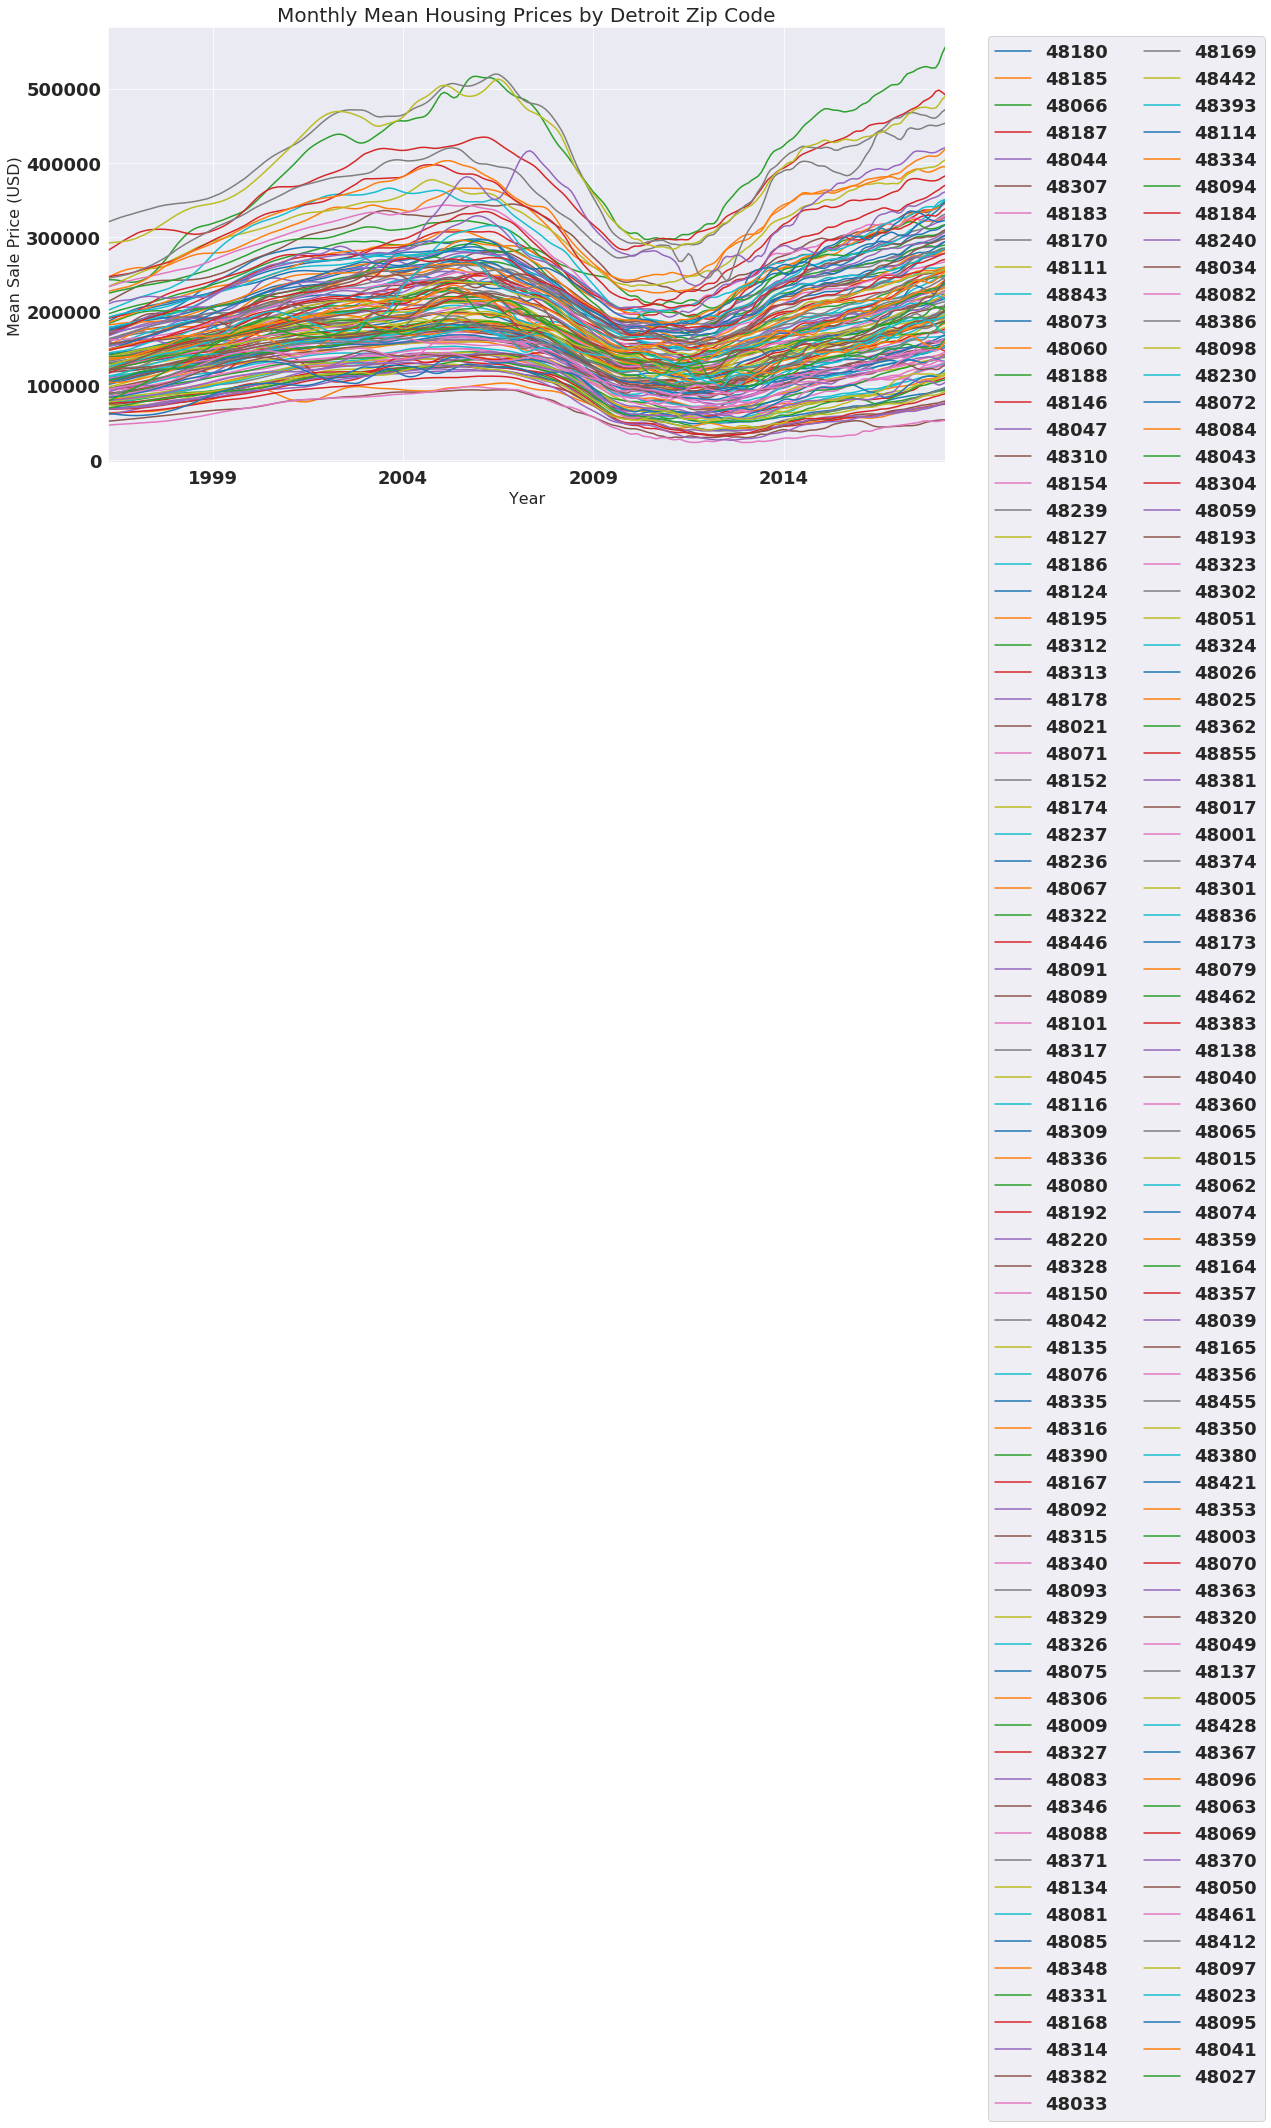

In [15]:
for zipcode in dtw.RegionName.unique():
    temp_df = dtw[dtw.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16)
plt.title("Monthly Mean Housing Prices by Detroit Zip Code", fontsize=20)

Text(0, 0.5, 'Mean Sale Price (USD)')

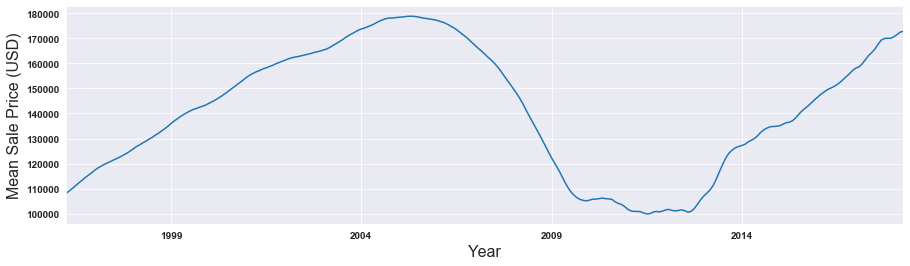

In [114]:
# The plot above has WAY too much info! 
# Let's isolate one zip code, and see what that looks like:

parents = dtw[dtw.RegionName == 48150]
parents['MeanValue'].plot(figsize=(15,4), label=48150)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16)

In [115]:
# I know contextually that this area was hit hard by the 2008 crash
# Let's look at more recent data, and see how the original chart is impacted

dtw_recent = dtw['2012':]
dtw_recent.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
2012-01-01,79040,48180,Taylor,MI,Detroit,Wayne,122,49100.0
2012-01-01,79044,48185,Westland,MI,Detroit,Wayne,239,70800.0
2012-01-01,78942,48066,Roseville,MI,Detroit,Macomb,580,40300.0
2012-01-01,79046,48187,Canton,MI,Detroit,Wayne,660,153700.0
2012-01-01,78926,48044,Macomb,MI,Detroit,Macomb,762,192700.0


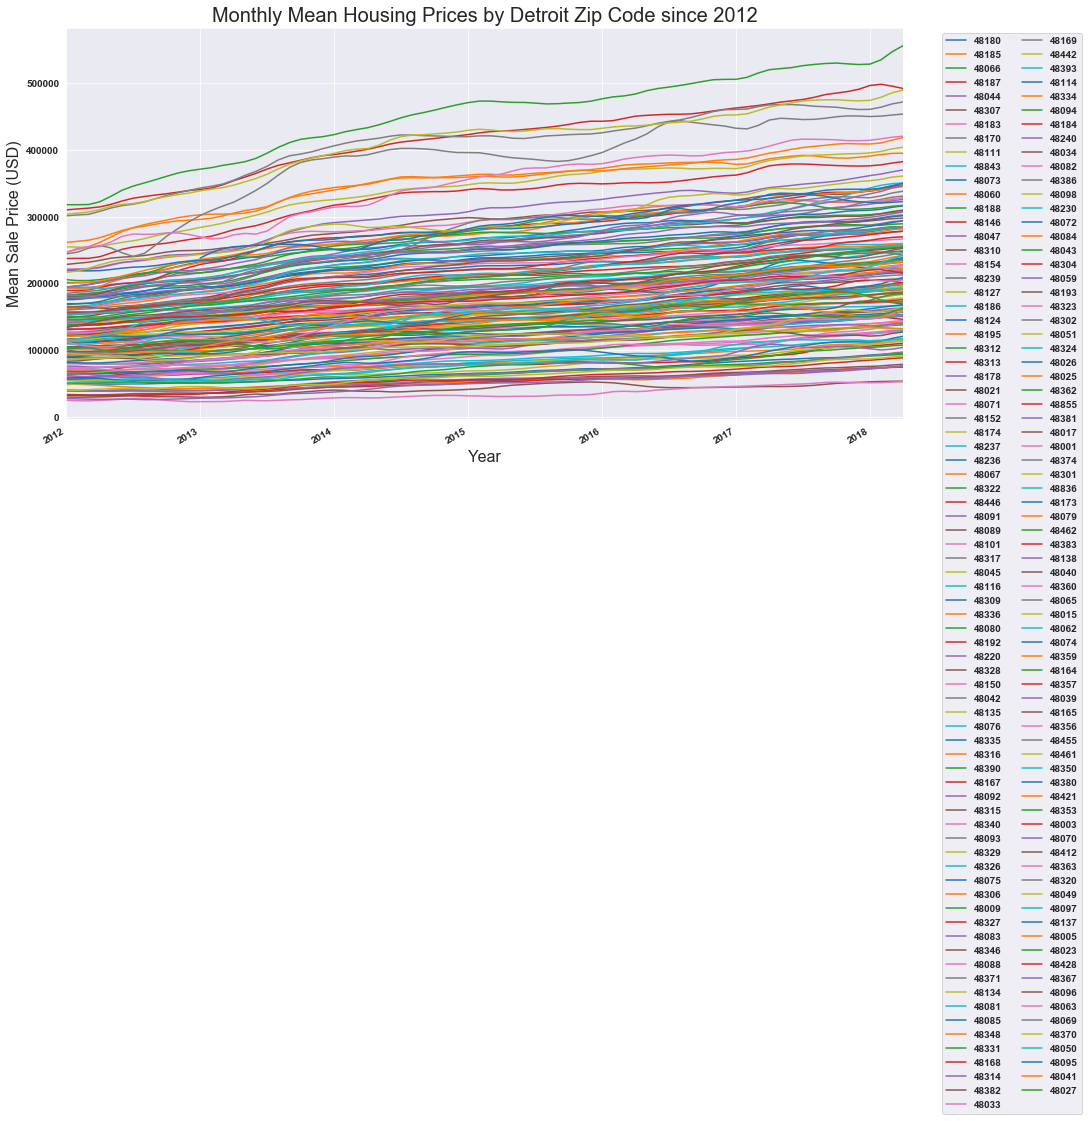

In [116]:
for zipcode in dtw_recent.RegionName.unique():
    temp_df = dtw_recent[dtw_recent.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16)
plt.title("Monthly Mean Housing Prices by Detroit Zip Code since 2012", fontsize=20)
plt.gcf().autofmt_xdate()

In [117]:
# I'm curious - what are the 10 highest (unique) zip codes, by mean value?
highmean_list = list(dtw_recent.sort_values(by='MeanValue', ascending=False).RegionName.unique()[:10])
print(highmean_list)

[48009, 48168, 48301, 48302, 48374, 48363, 48025, 48098, 48306, 48304]


In [118]:
dtw_recent.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
2012-01-01,79040,48180,Taylor,MI,Detroit,Wayne,122,49100.0
2012-01-01,79044,48185,Westland,MI,Detroit,Wayne,239,70800.0
2012-01-01,78942,48066,Roseville,MI,Detroit,Macomb,580,40300.0
2012-01-01,79046,48187,Canton,MI,Detroit,Wayne,660,153700.0
2012-01-01,78926,48044,Macomb,MI,Detroit,Macomb,762,192700.0


In [60]:
#placeholder for box and whiskers
#Generate a box and whiskers plot for temp_annual
from pandas import Grouper

# groups = dtw_recent.groupby(Grouper(freq='A'))
# #years = dtw_recent()
# for name, group in groups:
#     years[name.year] = group.values
# years.boxplot()
# pyplot.show()

NameError: name 'years' is not defined

In [48]:
#placeholder for heat map
# Transpose the yearly group DataFrame
#year_matrix = dtw_recent.T.asint()

# Draw a heatmap with matshow()
# plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
# plt.show()

In [120]:
parents_values = parents[['MeanValue']]
parents_values.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
MeanValue    265 non-null float64
dtypes: float64(1)
memory usage: 4.1 KB


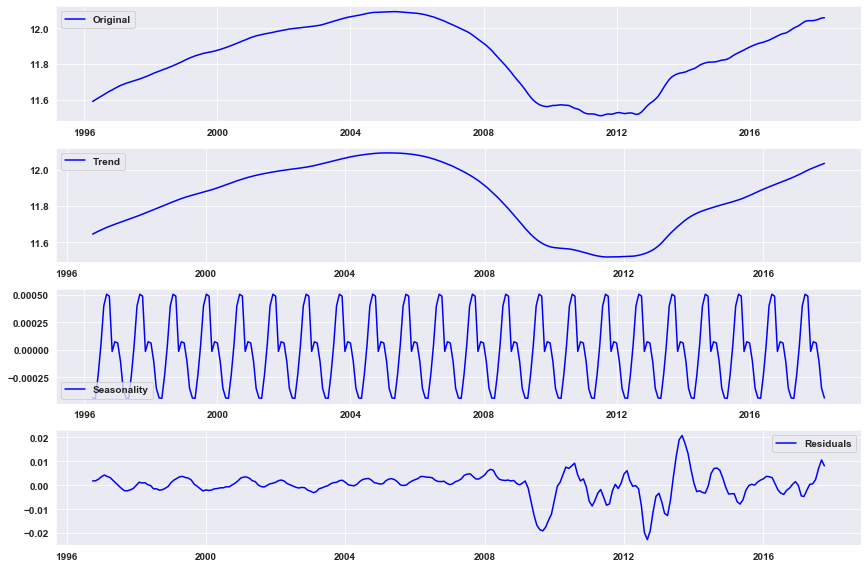

In [121]:
decomposition = seasonal_decompose(np.log(parents_values))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(parents_values), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

Great! So far we've looked at the details for one zip code, including seasonality, trend and residuals. Let's move onto modeling our region. 

# Step 5: ARIMA Modeling

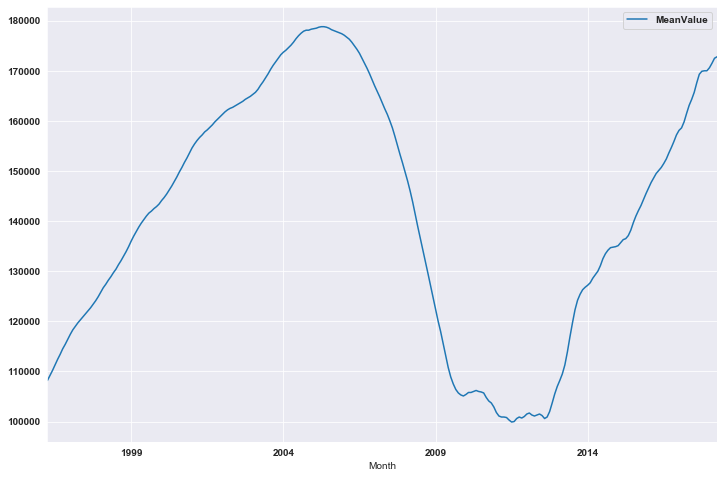

In [122]:
# We'll first build our model on a "test" zip code. 
# Here's what the values look like, without any pre-processing
parents_values.plot(figsize=(12, 8))
plt.show()

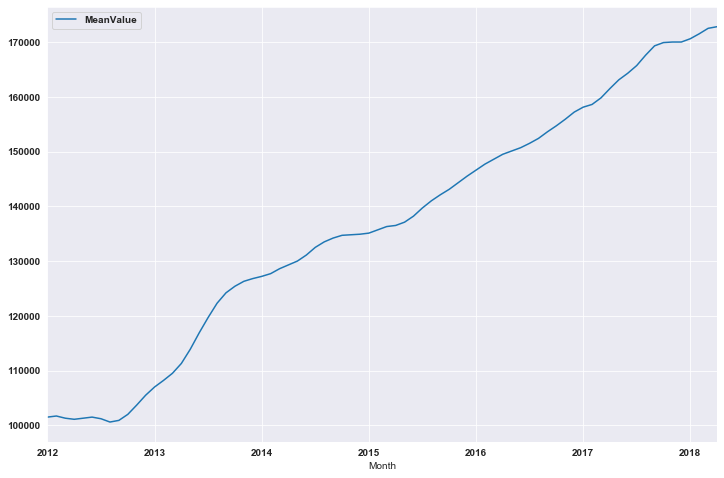

            MeanValue
Month                
2012-01-01   101500.0
2012-02-01   101700.0
2012-03-01   101300.0
2012-04-01   101100.0
2012-05-01   101300.0


In [123]:
# We want to remove values from before 2012 - let's do that now

parents_values = parents_values['2012':]
parents_values.plot(figsize=(12, 8))
plt.show()
print(parents_values.head())

Next, let's move on to building our SARIMAX model

In [124]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [125]:
mod = sm.tsa.statespace.SARIMAX(parents_values,
                                            order=comb[0],
                                            seasonal_order=combs[0],
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

TypeError: 'int' object is not subscriptable

In [126]:
parents_values.head()

,MeanValue
Month,
2012-01-01,101500.0
2012-02-01,101700.0
2012-03-01,101300.0
2012-04-01,101100.0
2012-05-01,101300.0


In [132]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

ans = []
for comb in pdq[1]:
    try:
        mod = sm.tsa.statespace.SARIMAX(parents_values,
                                        order=pdq,
                                        seasonal_order=pdqs[1],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
    except:
        continue
display(ans)

[]

In [67]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

TypeError: reduction operation 'argmin' not allowed for this dtype

In [55]:
# Check stationary test on one zipcode
# if it works, iterate through the region

# Define a function that will check for the stationarity of a time series
def stationarity_check(TS, column_name, rolling_window=7):    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = rolling_window, center = False).mean()
    rolstd = TS.rolling(window = rolling_window, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column_name]) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    pass

In [ ]:
# trends and seasonality, and allow for examining the residuals
def df_decompose(df):
    # Gather the trend, seasonality and noise of decomposed object
    trend = sd(df).trend
    seasonal = sd(df).seasonal
    residual = sd(df).resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.title(f"Decomposition for {df}")
    plt.subplot(411)
    plt.plot(df, label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();
    
    return residual.dropna()

In [ ]:
# define dataset here
decomp48150 = df_decompose(dtw[48150])_recent

In [57]:
# Drop missing values from residuals 
# ts_log_decompose = residual
# ts_log_decompose.dropna(inplace=True)

In [ ]:
# Placeholder
#group as monthly and plot hist

# Group the time series into monthly buckets
#CO2_monthly = CO2['co2'].resample('MS')

In [ ]:
# make stationary
# first, try plotting log transformation 
data = pd.Series(np.log(final_series), index=index)
fig = plt.figure(figsize=(12,6))
plt.plot(data, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Monthly sales)', fontsize=14)
plt.show()
# this is in Removing Trends

# Step 6: Interpreting Results

In [ ]:
# calculate for each zip diff between starting and prediction 
# profit and ROI
# how to account for risk?
# top 5 are the winners